# Fanal, a neutrino-less beta decay experiment 

## An open exercise

### Signal Estimation from data - Fitting

#### USC, Master de Física, Física de Partículas II


J. A. Hernando-Morata, with the help of J. Muñoz, J. M. Benlloch, B. Palmeiro, G. Díaz.

February 2021 - February 2022

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#### Importing modules

In [2]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.constants as constants
import scipy.stats     as stats
import scipy.optimize  as optimize

import warnings
warnings.filterwarnings('ignore')

In [3]:
# REMEMBER TO ADD your Fanal FOLDER TO PYTHONPATH
import os
import sys
import importlib
dirpath = os.getcwd()[:-9]
print('add path to PYTHONPATH : ', dirpath)
sys.path.insert(0, os.path.abspath(dirpath))

add path to PYTHONPATH :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal


In [5]:
import core.pltext  as pltext   # extensions for plotting histograms
import core.hfit    as hfit     # extension to fit histograms
import core.efit    as efit     # Fit Utilites - Includes Extend Likelihood Fit with composite PDFs
import core.utils   as ut       # generic utilities
import ana.fanal    as fn       # analysis functions specific to fanal
import     collpars as collpars # collaboration specific parameters
pltext.style()

## Indications

### Goal

  **Estimate the number of signal events in data. Estimate the half-life value**.

### Indications

   * Get the data
   
   * Estimate the number of signal events (using the energy spectrum fit to the samples: bb, bi, tl)
   
   * Measure the half-life.

## Main Parameters

In [6]:
coll   = 'new_delta'
erange = fn.erange 
eroi   = fn.eroi 
eblob2 = fn.eblob2

print('Data From               : {:s}'.format(coll))
print('Energy range            : ({:6.3f}, {:6.3f}) MeV'.format(*erange))
print('Blob-2 energy threshold : {:6.3f} MeV'.format(eblob2))
print('Energy RoI range        : ({:6.3f}, {:6.3f}) MeV'.format(*eroi))

Data From               : new_delta
Energy range            : ( 2.400,  2.700) MeV
Blob-2 energy threshold :  0.400 MeV
Energy RoI range        : ( 2.430,  2.480) MeV


In [7]:
varnames  = 'E', 'num_tracks', 'blob2_E'
varranges = erange, 1, (eblob2, 1.2)

print('selection ', varnames)
print('ranges    ', varranges)

selection  ('E', 'num_tracks', 'blob2_E')
ranges     ((2.4, 2.7), 1, (0.4, 1.2))


In [8]:
from collpars import nevts_Bi, unevts_Bi
from collpars import nevts_Tl, unevts_Tl
nevts  = (10   , nevts_Bi , nevts_Tl)
unevts = (False, unevts_Bi, unevts_Tl)
print('Total Events            ', nevts)
print('Uncertainty Total Events', unevts)

Total Events             (10, 4279.737, 62001.204)
Uncertainty Total Events (False, 118.231, 132.111)


## Access the data

In [9]:
filename = '/data/fanal_' + coll +'.h5'
print('Data : ', dirpath + filename)

mcbi = pd.read_hdf(dirpath + filename, key = 'mc/bi214')
mctl = pd.read_hdf(dirpath + filename, key = 'mc/tl208')
mcbb = pd.read_hdf(dirpath + filename, key = 'mc/bb0nu')

datab = pd.read_hdf(dirpath + filename, key = 'data/blind')
datar = pd.read_hdf(dirpath + filename, key = 'data/roi')
data  = pd.concat((datab, datar)) # concatenate blind and roi-data into one data DF

Data :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal/data/fanal_new_delta.h5


In [10]:
samples  = ['bb0nu', 'Bi', 'Tl']
ssamples = [r'$\beta\beta0\nu$', r'$^{214}$Bi', r'$^{208}$Tl']
mcs      = [mcbb, mcbi, mctl]

## Estimate the number of events

The *ana_experiment* method takes:

   * the data dample
   
   * the mc samples
   
   * the expected number of events in the fit
   
   * (optional) the uncertainties in the expected number of events, (in the case of uncertainties, the fit is constrained to those uncertainties)
   
   * See the help of the method for more info!


### constrained fit 

Constraint to the number of bkg events expected using the blind sample

Expected events                [5.191031992610631, 77.72418817293634, 451.23145075273135]
Uncertainties expected events  [0.0, 2.1471900006646285, 0.9614754931274252]
Estimated Events  [ 34.08602896  78.04847571 451.29097364]
New estimation  [ 34.22523723  77.72418817 451.23145075]


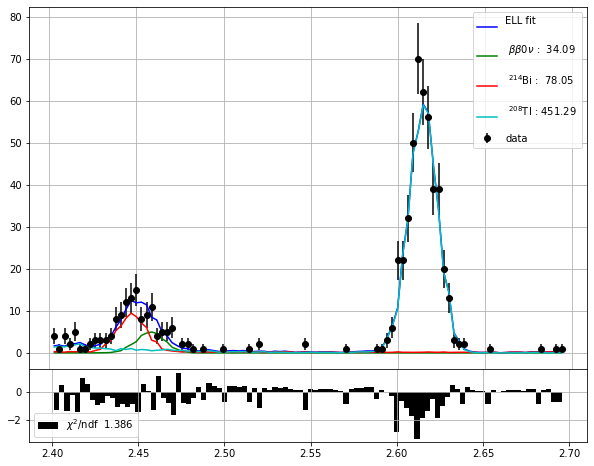

In [49]:
# selection and efficiencies
anadat = ut._select_sample(data, varnames, varranges)
anamcs = [ut._select_sample(mc, varnames, varranges) for mc in mcs]
effs   = [float(len(amc)/len(mc)) for amc, mc in zip(anamcs, mcs)]

# set the number of events
mevts   = [n * eff for n, eff in zip(nevts , effs)]
umevts  = [n * eff for n, eff in zip(unevts, effs)]
print('Expected events               ', mevts)
print('Uncertainties expected events ', umevts)

# mc for the pds 
refmcs  = [ut._select_sample(mc, varnames[:-1], varranges[:-1]) for mc in mcs]

# fit
res, enes, ell = fn.fit_ell(anadat, refmcs, mevts, umevts)
fn.plot_fit_ell(enes, res.x, ell)
print('Estimated Events ', res.x)

mask = (True, False, False)
resp = ell.best_estimate(enes, *mevts, mask = mask)
print('New estimation ', resp.x)

In [37]:
x0          = 5
res.x[mask] = np.array(5, float)
res.x
print(x0, mask, res.x)

5 (True, False, False) [ 34.08602896  78.04847571 451.29097364]


selection variables  : ['E', 'num_tracks', 'blob2_E']
selection ranges     : [(2.4, 2.65), (1.0, 1.1), (0.4, inf)]
selection mc samples : ['E', 'num_tracks']
data size            : 594
mc sizes             : [30217, 6678, 31548]
efficiencies         :   0.52, 1.76e-02, 7.26e-03
Initial       Events :   5.19,  75.45, 450.06
Uncertainties Events :   0.00,   2.08,   0.96
Fit success          :  True
Estimated     Events :  34.59,  75.69, 450.12


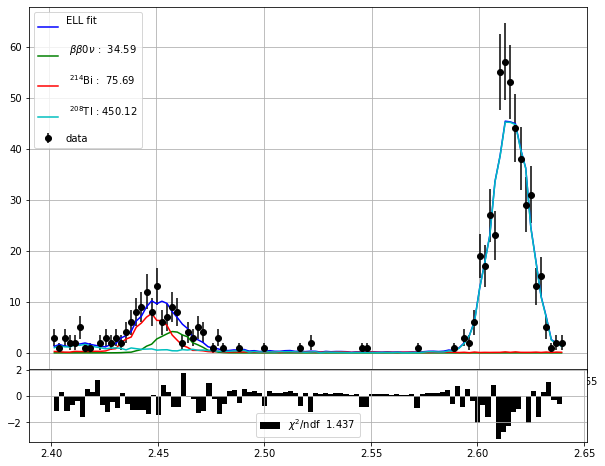

In [9]:
result, enes, ell = fn.ana_experiment(data, mcs, nevts, unevts, bins = 180)
ns_est = result.x # number of estimated events

### Unconstrained Fit

Repeat the fit without the constraint in the number of background events

To cross-check!

selection variables  : ['E', 'num_tracks', 'blob2_E']
selection ranges     : [(2.4, 2.65), (1.0, 1.1), (0.4, inf)]
selection mc samples : ['E', 'num_tracks']
data size            : 594
mc sizes             : [30217, 6678, 31548]
efficiencies         :   0.52, 1.76e-02, 7.26e-03
Initial       Events :   5.19,  75.45, 450.06
Fit success          :  True
Estimated     Events :  30.47,  83.87, 479.68


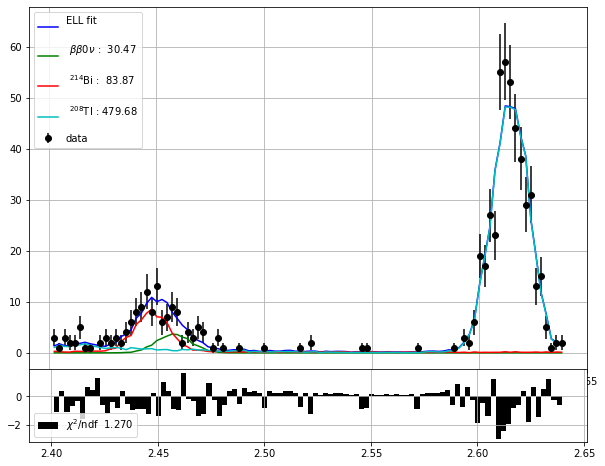

In [10]:
_ = fn.ana_experiment(data, mcs, nevts, bins = 180)

### Plot contributions

selection variables  : ['E', 'num_tracks', 'blob2_E']
selection ranges     : [(2.4, 2.65), (1.0, 1.1), (0.4, inf)]
selection mc samples : ['E', 'num_tracks']
data size            : 594
mc sizes             : [30217, 6678, 31548]
efficiencies         :   0.52, 1.76e-02, 7.26e-03


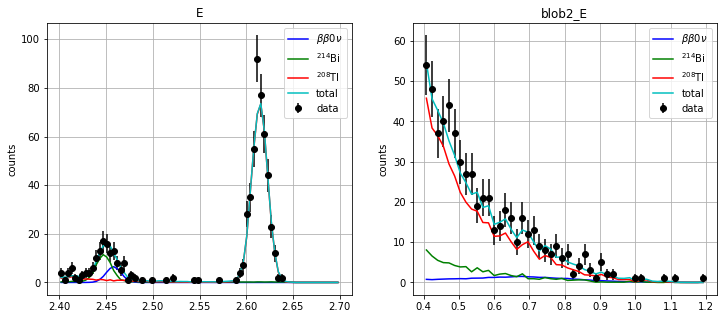

In [11]:
anadata, anamcs, effs = fn.ana_samples(data, mcs) 
subplot = pltext.canvas(2)
subplot(1); 
fn.plot_contributions(anadata, anamcs, ns_est)
subplot(2);
fn.plot_contributions(anadata, anamcs, ns_est, 'blob2_E', (0.4, 1.2), nbins = 50);

## Estime the half-life

In [12]:
eff_bb     = effs[0]
nevts_bb   = ns_est[0]
acc_bb     = collpars.acc_bb
exposure   = collpars.exposure
eff        = acc_bb * eff_bb
tau        = fn.half_life(nevts_bb, exposure, eff)

print('number of bb0nu events  : {:6.3f}'.format(nevts_bb))
print('exposure                : {:6.2f} kg y'.format(exposure))
print('total signal efficiency : {:6.3f}'.format(eff))
print('bb0nu half-life         : {:6.2e} y '.format(tau))

AttributeError: module 'collpars' has no attribute 'acc_bb'

## Write Out

In [13]:
write = True

if (write):
    of = open('collpars.py', 'a')
    of.write('nevts_bb_fit    = {:6.3f}'.format(nevts_bb)+'\n')
    of.write('eff_bb_fit      = {:6.3f}'.format(eff_bb)+'\n')
    of.write('tau             = {:1.3e}'.format(tau)+' # y \n')
    of.close()